In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None) 

#plt.style.use('seaborn')
sns.set_theme(style="white")

train_df = pd.read_csv('data/train_ml.csv', index_col=0)
test_df = pd.read_csv('data/test_ml.csv', index_col=0)

# II. Feature engineering

In [3]:
def clean_mail_type(etype):
    if type(etype) != str and np.isnan(etype):
        return 'text/plain'
    if (('multipart/' in etype or etype == 'text/calendar') and not(etype in ['multipart/alternative', 'multipart/mixed'])):
        return 'multipart/others'
    else:
        return etype.strip().lower()

In [4]:
def clean_date(date):
    # Remove occurences of GMT
    pre_date = date.split('GMT', 1)[0].split('(', 1)[0]
    
    # replace - with ' '
    pre_date = pre_date.replace('-', ' ')
    
    # remove multiple spaces
    pre_date = ' '.join(pre_date.split())
    
    # remove space at the beginning and the end
    words_list = pre_date.strip().split(' ')
    
    if words_list[0][:-1].isalpha():
        # We have the weekday
        words_list.pop(0)
    if len(words_list[0]) == 1:
        words_list[0] = '0' + words_list[0]
    assert len(words_list[0]) == 2, 'For date ' + date
    
    words_list[1] = words_list[1].capitalize()
    
    if len(words_list[2]) == 2:
        words_list[2] = '20' + words_list[2]
    assert len(words_list[2]) == 4, 'For date ' + date
              
    # Remove parenthesis
    if not(words_list[-1][0] in ['+', '-']):
        if words_list[-1][0] == '(':
            words_list.pop()

        # Add +0000 if not precised
        if not(words_list[-1][0] in ['+', '-']):
            if words_list[-1].isnumeric():
                words_list[-1] = '+' + words_list[-1]
            else:
                words_list.append('+0000')
        
    # Correct some errors
    if int(words_list[-1][3:]) > 60:
        words_list[-1] = str(int(words_list[-1][1:3])+1) + '00'
        if len(words_list[-1]) == 3:
            words_list[-1] = '+0' + words_list[-1]
        else:
            words_list[-1] = '+' + words_list[-1]
                
    assert int(words_list[-1][3:]) <= 60, 'For date ' + date + '. UTC offset : ' + words_list[-1]
    clean_date = ' '.join(''.join(map(str, word)) for word in words_list)
    assert len(clean_date) == 26, 'For date ' + date + '. Output : ' + clean_date + '. Len : ' + str(len(clean_date))
    return clean_date

In [5]:
def clean_timezone(date):
    # Remove occurences of GMT
    pre_date = date.split('GMT', 1)[0].split('(', 1)[0]
    
    # replace - with ' '
    pre_date = pre_date.replace('-', ' ')
    
    # remove multiple spaces
    pre_date = ' '.join(pre_date.split())
    
    # remove space at the beginning and the end
    words_list = pre_date.strip().split(' ')
    
    if words_list[0][:-1].isalpha():
        # We have the weekday
        words_list.pop(0)
    if len(words_list[0]) == 1:
        words_list[0] = '0' + words_list[0]
    assert len(words_list[0]) == 2, 'For date ' + date
    
    words_list[1] = words_list[1].capitalize()
    
    if len(words_list[2]) == 2:
        words_list[2] = '20' + words_list[2]
    assert len(words_list[2]) == 4, 'For date ' + date
              
    # Remove parenthesis
    if not(words_list[-1][0] in ['+', '-']):
        if words_list[-1][0] == '(':
            words_list.pop()

        # Add +0000 if not precised
        if not(words_list[-1][0] in ['+', '-']):
            if words_list[-1].isnumeric():
                words_list[-1] = '+' + words_list[-1]
            else:
                words_list.append('+0000')
        
    # Correct some errors
    if int(words_list[-1][3:]) > 60:
        words_list[-1] = str(int(words_list[-1][1:3])+1) + '00'
        if len(words_list[-1]) == 3:
            words_list[-1] = '+0' + words_list[-1]
        else:
            words_list[-1] = '+' + words_list[-1]
                
    assert int(words_list[-1][3:]) <= 60, 'For date ' + date + '. UTC offset : ' + words_list[-1]
    clean_date = words_list[-1]
    assert len(clean_date) == 5, 'For date ' + date + '. Output : ' + clean_date + '. Len : ' + str(len(clean_date))
    return clean_date[1:]

In [6]:
X_full = train_df.copy(deep=True)
X_full_test = test_df.copy(deep=True)

y_col = ['updates', 'personal', 'promotions', 'forums', 'purchases', 'travel', 'spam', 'social']
y = X_full[y_col]
X_full.drop(y_col, axis=1, inplace=True)

In [7]:
X_full['date'] = pd.to_datetime(train_df['date'].apply(clean_date), format="%d %b %Y %X %z", utc=True)
X_full_test['date'] = pd.to_datetime(test_df['date'].apply(clean_date), format="%d %b %Y %X %z", utc=True)

In [8]:
X_full['timezone'] = train_df['date'].apply(clean_timezone)
X_full_test['timezone'] = test_df['date'].apply(clean_timezone)

In [9]:
X_full['mail_type'] = X_full['mail_type'].apply(clean_mail_type)
X_full_test['mail_type'] = X_full_test['mail_type'].apply(clean_mail_type)

In [10]:
X_full['images/body'] = X_full['images']/X_full['chars_in_body']
X_full_test['images/body'] = X_full_test['images']/X_full_test['chars_in_body']

In [11]:
X_full['salutations&designation'] = X_full['salutations'] & X_full['designation']
X_full_test['salutations&designation'] = X_full_test['salutations'] & X_full_test['designation']

We verify that the stratification was good.

In [12]:
#y_test.sum(axis=0)/(y_train.sum(axis=0) + y_test.sum(axis=0))

We now do some feature engineering.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import date

class DateTransformer(BaseEstimator, TransformerMixin):
    """Transformer for date."""
    def __init__(self, active=True):
        self.active=active
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        if self.active:
            X_new['year'] = X['date'].dt.year
            X_new['month//2'] = X['date'].dt.month//2
            X_new['weekday'] = X['date'].dt.weekday
            X_new['trimester_from_2012'] = (X['date'].dt.date- date(2012,1,1)).dt.days//(7*13)
            X_new['hours'] = X['date'].dt.hour
        return X_new[['year', 'month//2', 'weekday', 'trimester_from_2012', 'hours']]

class BoundedLabelTransformer(BaseEstimator, TransformerMixin):
    """Transformer for org, tld and timezone."""
    def __init__(self, org=56, tld=23, timezone=8):
        self.org = org
        self.tld = tld
        self.timezone = timezone
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X[['org', 'tld', 'timezone']].copy()
        for column in ['org', 'tld', 'timezone']:
            if column == 'timezone':
                keep_labels = list(X[column].value_counts()[:self.timezone].index)
                X_new[column] = X_new[column].apply(lambda x : x if x in keep_labels else '0000')
            else:
                X_new[column] = X_new[column].fillna('unknown')
                if column == 'org':
                    keep_labels = list(X[column].value_counts()[:self.org].index)
                else:
                    keep_labels = list(X[column].value_counts()[:self.tld].index)
                X_new[column] = X_new[column].apply(lambda x : x if x in keep_labels else '__others')
        return X_new


class BoundedOrdinalTransformer(BaseEstimator, TransformerMixin):
    """Transformer for images and urls."""
    def __init__(self, images=10, urls=50):
        self.images = images
        self.urls = urls
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X[['images', 'urls']].copy()
        
        for column in ['images', 'urls']:
            X_new[column] = X_new[column].fillna(0)
            if column == 'images':
                X_new[column] = X_new[column].apply(lambda x : x if x < self.images else self.images)
            else:
                X_new[column] = X_new[column].apply(lambda x : x if x < self.urls else self.urls) 
        
        #X_new['images/body'] = X['images']/X['chars_in_body']
        return X_new.values

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

date_cat = ['date']
bounded_label_cat = ['org', 'tld', 'timezone']
bounded_ordinal_cat = ['images', 'urls']
binary_cat = ['ccs', 'bcced', 'salutations', 'designation', 'salutations&designation']
label_cat = ['mail_type']
continuous_cat = ['chars_in_subject', 'chars_in_body', 'images/body']

Bounded_label_lin = make_pipeline(
    BoundedLabelTransformer(org=56, tld=23, timezone=8),
    OneHotEncoder(handle_unknown='ignore')
)

Label_lin = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='text/plain'),
    OneHotEncoder(handle_unknown='ignore')
)

Countinuous_lin = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler()
)

processor_lin = make_column_transformer(
    (DateTransformer(active=True), date_cat),
    (Bounded_label_lin, bounded_label_cat),
    (BoundedOrdinalTransformer(images=10, urls=50), bounded_ordinal_cat),
    (Label_lin, label_cat),
    (Countinuous_lin, continuous_cat),
    (SimpleImputer(strategy='constant', fill_value=0), binary_cat)
)

# III. Testing models

In [15]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem

classifiers = {
#    'duc' : make_pipeline(processor_lin, OneVsRestClassifier(DummyClassifier(strategy='prior', random_state=1))),
    'rfc' : make_pipeline(processor_lin, OneVsRestClassifier(RandomForestClassifier(random_state=1))),
#    'gbc' : make_pipeline(processor_lin, OneVsRestClassifier(GradientBoostingClassifier(random_state=1))),
    'xgc' : make_pipeline(processor_lin, OneVsRestClassifier(XGBClassifier(random_state=1, verbose=True, eval_metric='logloss'))),
#    'mpc' : make_pipeline(processor_lin, OneVsRestClassifier(MLPClassifier(random_state=1))),
#    'sgd' : make_pipeline(processor_lin, Nystroem(n_components=3000, random_state=1), OneVsRestClassifier(SGDClassifier(loss='log', random_state=1))),
}

Iterating over all classifiers before making fine tuning.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

res_clf = {}
for name, classifier in classifiers.items():
    print('Training', name, '...')
    if name=='xgc':
        X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=1, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1, stratify=y_train) # 0.20 x 0.75 = 0.15
        
        classifier.set_params(onevsrestclassifier__estimator__eval_set=[(X_train, y_train), (X_test, y_test)])
        %time classifier.fit(X_train, y_train)
        
        y_test_pred = classifier.predict_proba(X_test)
        res_clf[name] = log_loss(y_test, y_test_pred)   

    else:
        X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=1, stratify=y)
        
        %time classifier.fit(X_train, y_train)
        
        y_test_pred = classifier.predict_proba(X_test)
        res_clf[name] = log_loss(y_test, y_test_pred) 

    print(res_clf[name])

We have the following input :
```
Training duc ...
Wall time: 189 ms
2.2743314534065138
Training rfc ...
Wall time: 48.2 s
1.1948558276322874
Training gbc ...
Wall time: 28.7 s
1.382503328344713
Training xgc ...
Wall time: 7.18 s
1.3540913110325103
Training mpc ...
Wall time: 52.9 s
1.6615107416581647
Training sgd ...
Wall time: 1min 25s
1.5890009699425305
Training svc ...
```
We notice that SVC takes too more times to fit. We will not consider it. We notice that the most promising algorithms is the **Random Forest**.

## IV. Fine Tuning

### 1. What is the best n_estimators for the Random Forest Classifier ?

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

param_grid = {
    'onevsrestclassifier__estimator__n_estimators': [50,100,200,300,400,500]
}

grid_search=GridSearchCV(
    estimator=classifiers['rfc'],
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=4,
    verbose=1,
    n_jobs=-1,
    return_train_score=True)

X_full_drop, _, y_drop, _ = train_test_split(X_full, y, test_size=0.33, random_state=1, stratify=y) # drop 33% of the data

%time grid_search.fit(X_full_drop, y_drop)
print('Done!')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 19.4min finished


Wall time: 22min 36s
Done!


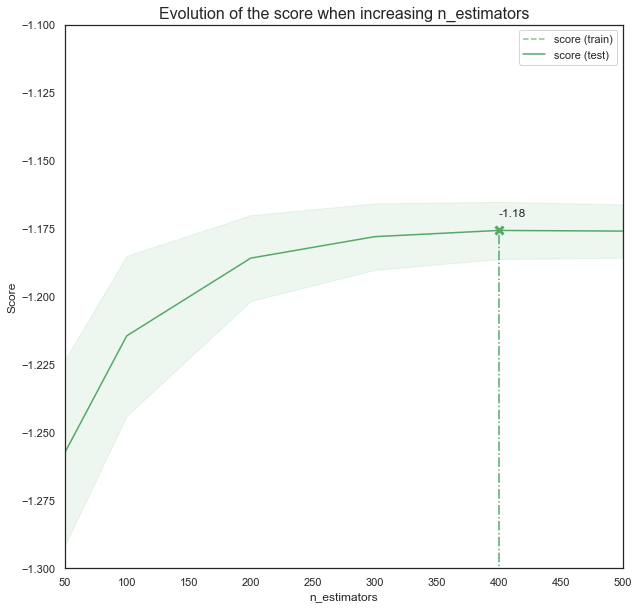

In [22]:
results = grid_search.cv_results_
plt.figure(figsize=(10, 10))
plt.title("Evolution of the score when increasing n_estimators",
          fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(param_grid['onevsrestclassifier__estimator__n_estimators']),max(param_grid['onevsrestclassifier__estimator__n_estimators']))
ax.set_ylim(-1.3, -1.1)

X_axis = np.array(results['param_onevsrestclassifier__estimator__n_estimators'].data, dtype=int)


for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = results['mean_%s_%s' % (sample, 'score')]
    sample_score_std = results['std_%s_%s' % (sample, 'score')]
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0, color='g')
    ax.plot(X_axis, sample_score_mean, style, color='g',
            alpha=1 if sample == 'test' else 0.7,
            label="%s (%s)" % ('score', sample))

best_index = np.nonzero(results['rank_test_%s' % 'score'] == 1)[0][0]
best_score = results['mean_test_%s' % 'score'][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [best_score-10, best_score],
        linestyle='-.', color='g', marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

### 2. What is the best max_features ?

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

make_pipeline(processor_lin, OneVsRestClassifier(RandomForestClassifier(random_state=1)))

param_grid = {
    'onevsrestclassifier__estimator__max_features': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}

grid_search=GridSearchCV(
    estimator=classifiers['rfc'],
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=4,
    verbose=1,
    n_jobs=-1,
    return_train_score=True)

X_full_drop, _, y_drop, _ = train_test_split(X_full, y, test_size=0.33, random_state=1, stratify=y) # drop 33% of the data

%time grid_search.fit(X_full_drop, y_drop)
print('Done!')

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 16.2min finished


Wall time: 17min 27s
Done!


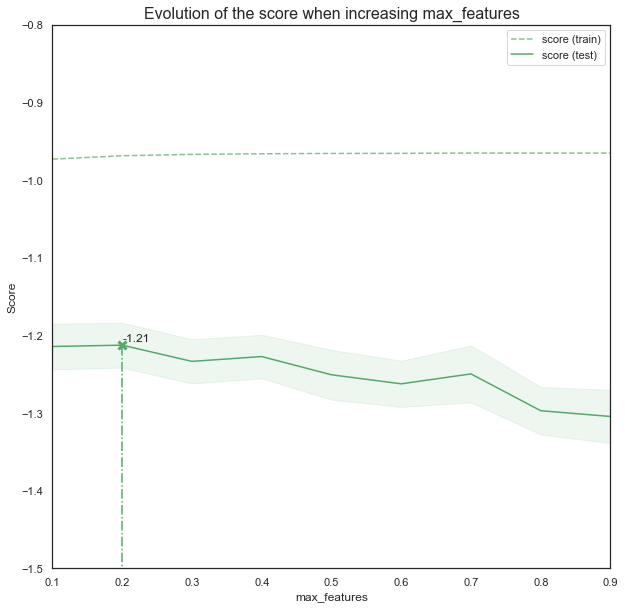

In [35]:
results = grid_search.cv_results_
plt.figure(figsize=(10, 10))
plt.title("Evolution of the score when increasing max_features",
          fontsize=16)

plt.xlabel("max_features")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(param_grid['onevsrestclassifier__estimator__max_features']),max(param_grid['onevsrestclassifier__estimator__max_features']))
ax.set_ylim(-1.5, -0.8)

X_axis = np.array(results['param_onevsrestclassifier__estimator__max_features'].data, dtype=float)


for sample, style in (('train', '--'), ('test', '-')):
    sample_score_mean = results['mean_%s_%s' % (sample, 'score')]
    sample_score_std = results['std_%s_%s' % (sample, 'score')]
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0, color='g')
    ax.plot(X_axis, sample_score_mean, style, color='g',
            alpha=1 if sample == 'test' else 0.7,
            label="%s (%s)" % ('score', sample))

best_index = np.nonzero(results['rank_test_%s' % 'score'] == 1)[0][0]
best_score = results['mean_test_%s' % 'score'][best_index]

# Plot a dotted vertical line at the best score for that scorer marked by x
ax.plot([X_axis[best_index], ] * 2, [best_score-10, best_score],
        linestyle='-.', color='g', marker='x', markeredgewidth=3, ms=8)

# Annotate the best score for that scorer
ax.annotate("%0.2f" % best_score,
            (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

### 3. Is it interesting to fine-tune estimators by class?

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

param_grid = {
    'randomforestclassifier__n_estimators': [50,100,150,200,300,400,500]
}

labels = [
    'updates',
    'personal',
    'promotions',
    'forums',
    'purchases',
    'travel',
    'spam',
    'social'
]

results_estimators = {}
for label in labels:
    print("Training for", label, "...")
    clf = make_pipeline(processor_lin, RandomForestClassifier(random_state=1))
    y_class = y[label]
    
    grid_search=GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring='neg_log_loss',
        cv=4,
        verbose=0,
        n_jobs=4,
        return_train_score=True,
        refit=False
    )

    X_full_drop, _, y_drop, _ = train_test_split(X_full, y_class, test_size=0.95, random_state=1, stratify=y_class) # drop 33% of the data
    %time grid_search.fit(X_full_drop, y_drop)
    results_estimators[label] = grid_search.cv_results_
    
print('Done!')

Training for updates ...
Wall time: 28 s
Training for personal ...
Wall time: 21.5 s
Training for promotions ...
Wall time: 24.5 s
Training for forums ...
Wall time: 21.2 s
Training for purchases ...
Wall time: 14.5 s
Training for travel ...
Wall time: 13.2 s
Training for spam ...
Wall time: 13.2 s
Training for social ...
Wall time: 19.3 s
Done!


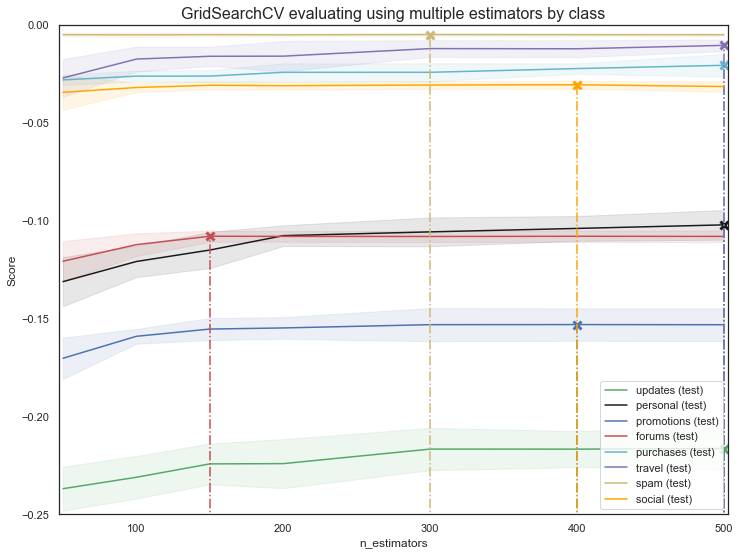

In [62]:
plt.figure(figsize=(12, 9))
plt.title("GridSearchCV evaluating using multiple estimators by class", fontsize=16)

plt.xlabel("n_estimators")
plt.ylabel("Score")

n_estimators_min = min(param_grid['randomforestclassifier__n_estimators']) - 3
n_estimators_max = max(param_grid['randomforestclassifier__n_estimators']) + 3

ax = plt.gca()
ax.set_xlim(n_estimators_min, n_estimators_max)
ax.set_ylim(-0.25, 0)

# Get the regular numpy array from the MaskedArray

for label, color in zip(labels, ['g', 'k', 'b', 'r', 'c', 'm', 'y', 'orange']):
    results = results_estimators[label]
    X_axis = np.array(results['param_randomforestclassifier__n_estimators'].data, dtype=int)
    sample, style = ('test', '-')

    sample_score_mean = results['mean_%s_%s' % (sample, 'score')]
    sample_score_std = results['std_%s_%s' % (sample, 'score')]
    ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                    sample_score_mean + sample_score_std,
                    alpha=0.1 if sample == 'test' else 0, color=color)
    ax.plot(X_axis, sample_score_mean, style, color=color,
            alpha=1 if sample == 'test' else 0,
            label="%s (%s)" % (label, sample))

    best_index = np.nonzero(results['rank_test_%s' % 'score'] == 1)[0][0]
    best_score = results['mean_test_%s' % 'score'][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [best_score-10, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

plt.legend(loc="best")
plt.grid(False)
plt.show()

### 4. Testing Charles' Idea

In [100]:
from sklearn.base import BaseEstimator, ClassifierMixin

class ProbabilisticClassifier(BaseEstimator, ClassifierMixin):
    '''Must be called at the very beginning of the pipeline'''

    def __init__(self, threshold=0.1):
        self.threshold = treshold

    def fit(self, X, y):
        '''Need dataframe as input...'''
        train_df = pd.concat([X_full,y], axis=1)
        self.labels = list(y.columns)
        
        self.y_proba = train_df.groupby(by='org').mean()[self.labels]
        self.select_df = (self.y_proba < threshold) | (self.y_proba > (1-threshold))
        self.orgs = set(train_df.org.unique())
        return self

    def predict(self, X):
        results_df = pd.DataFrame(0, index=X.index, columns=self.labels)
        
        for idx, row in X.iterrows():
            if row['org'] in self.orgs:
                results_df.loc[idx] = self.y_proba*self.select_df
        
        return results_df

In [101]:
proba_clf = ProbabilisticClassifier()
proba_clf.fit(X_full, y)

ProbabilisticClassifier()

In [102]:
proba_clf.predict(X_test)

ValueError: Incompatible indexer with Series

In [75]:
threshold = 0.1

y_proba = train_df.groupby(by='org').mean()[list(y.columns)]
df_proba = (y_proba < threshold) | (y_proba > (1-threshold))
print('More than {0:.0%} of the train data can be predict with it.'.format(((df_proba*1).apply(lambda x : min(x), axis=1)).mean()))

More than 68% of the train data can be predict with it.


In [90]:
results_df = pd.DataFrame(0, index=[1,2], columns=labels)


updates       0
personal      0
promotions    0
forums        0
purchases     0
travel        0
spam          0
social        0
Name: 1, dtype: int64

In [63]:
for idx, row in X_full.iterrows():
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022


5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714


8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436


11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
11069
11070
11071
11072
11073
11074
11075
11076
11077
11078
11079
11080
11081
11082
11083
11084
11085
11086
11087
11088
11089
11090
11091
11092
11093
11094
11095
11096
11097
11098
11099
11100
11101
11102
11103
11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
1120

12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
12644
12645
12646
12647
12648
12649
12650
12651
12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663
12664
12665
12666
12667
12668
12669
12670
12671
12672
12673
12674
12675
12676
12677
12678
1267

14898
14899
14900
14901
14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
1506

16401
16402
16403
16404
16405
16406
16407
16408
16409
16410
16411
16412
16413
16414
16415
16416
16417
16418
16419
16420
16421
16422
16423
16424
16425
16426
16427
16428
16429
16430
16431
16432
16433
16434
16435
16436
16437
16438
16439
16440
16441
16442
16443
16444
16445
16446
16447
16448
16449
16450
16451
16452
16453
16454
16455
16456
16457
16458
16459
16460
16461
16462
16463
16464
16465
16466
16467
16468
16469
16470
16471
16472
16473
16474
16475
16476
16477
16478
16479
16480
16481
16482
16483
16484
16485
16486
16487
16488
16489
16490
16491
16492
16493
16494
16495
16496
16497
16498
16499
16500
16501
16502
16503
16504
16505
16506
16507
16508
16509
16510
16511
16512
16513
16514
16515
16516
16517
16518
16519
16520
16521
16522
16523
16524
16525
16526
16527
16528
16529
16530
16531
16532
16533
16534
16535
16536
16537
16538
16539
16540
16541
16542
16543
16544
16545
16546
16547
16548
16549
16550
16551
16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566
1656

18011
18012
18013
18014
18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026
18027
18028
18029
18030
18031
18032
18033
18034
18035
18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047
18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
1817

19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532
19533
19534
19535
19536
19537
19538
19539
19540
19541
19542
19543
19544
19545
19546
19547
19548
19549
19550
19551
19552
19553
19554
19555
19556
19557
19558
19559
19560
19561
19562
19563
19564
19565
19566
19567
19568
19569
19570
19571
19572
19573
19574
19575
19576
19577
19578
19579
19580
19581
19582
19583
19584
19585
19586
19587
19588
19589
19590
19591
19592
19593
19594
19595
19596
19597
19598
19599
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
1967

21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
2117

22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
2260

23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
2410

26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
2676

29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
2946

30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
3084

KeyboardInterrupt: 

In [40]:
list(y.columns)

['updates',
 'personal',
 'promotions',
 'forums',
 'purchases',
 'travel',
 'spam',
 'social']

### 5. GridSearch and Randomized Search

Using the help of Tony to fine tune, we obtain the following results for the Randomized Search :


- 1th time :
```{'onevsrestclassifier_estimator_n_estimators': 700, 'onevsrestclassifierestimatormin_samples_split': 4, 'onevsrestclassifierestimatormin_samples_leaf': 1, 'onevsrestclassifierestimator_bootstrap': False, 'columntransformerpipeline-1boundedlabeltransformertld': 20, 'columntransformerpipeline-1boundedlabeltransformerorg': 50, 'columntransformer_boundedordinaltransformer_urls': 20, 'columntransformer_boundedordinaltransformer_images': 8}```



- 2th time :
```{"onevsrestclassifier__estimator__n_estimators": 800, "onevsrestclassifier__estimator__min_samples_split": 4, "onevsrestclassifier__estimator__min_samples_leaf": 1, "onevsrestclassifier__estimator__bootstrap": False, "columntransformer__pipeline-1__boundedlabeltransformer__tld": 20, "columntransformer__pipeline-1__boundedlabeltransformer__org": 50, "columntransformer__boundedordinaltransformer__urls": 50, "columntransformer__boundedordinaltransformer__images": 5}```

In [24]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'columntransformer__pipeline-1__boundedlabeltransformer__org' : [50],
    'columntransformer__pipeline-1__boundedlabeltransformer__tld' : [20],
    'columntransformer__boundedordinaltransformer__images' : [8],
    'columntransformer__boundedordinaltransformer__urls' : [20],
    'onevsrestclassifier__estimator__bootstrap': [True, True, False],
    'onevsrestclassifier__estimator__min_samples_leaf': [1,1,2,3,5,10,50],
    'onevsrestclassifier__estimator__min_samples_split': [2,3,4,4,5,7,10],
    'onevsrestclassifier__estimator__n_estimators': [500,600,700,800,900]
}

number_possibilites = 1
for key, value in param_dist.items():
    number_possibilites = number_possibilites * len(value)

print("There are", str(number_possibilites), "possibilites for the RandomizedSearchCV.")

There are 735 possibilites for the RandomizedSearchCV.


In [ ]:
from sklearn.metrics import log_loss

random_search =RandomizedSearchCV(
    estimator=classifiers['rfc'],
    param_distributions=param_dist,
    scoring='neg_log_loss',
    n_iter=8,
    cv=5,
    verbose=1,
    random_state=1,
    n_jobs=-1,
    return_train_score=True)

%time random_search.fit(X_full, y)
random_search.best_params_

In [14]:
import json
with open('ml_groundtruth/results_best_params.json', "r") as f:
    results_best_params = json.load(f)
with open('ml_groundtruth/results_summary.json', "r") as f:
    results_summary = json.load(f)

In [42]:
from sklearn.model_selection import GridSearchCV
param_dist = {
    'columntransformer__pipeline-1__boundedlabeltransformer__org' : [30],
    'columntransformer__pipeline-1__boundedlabeltransformer__tld' : [20],
    'columntransformer__boundedordinaltransformer__images' : [5],
    'columntransformer__boundedordinaltransformer__urls' : [20],
    'onevsrestclassifier__estimator__bootstrap': [True, False],
    'onevsrestclassifier__estimator__min_samples_leaf': [5],
    'onevsrestclassifier__estimator__min_samples_split': [4],
    'onevsrestclassifier__estimator__n_estimators': [500,600,700,800,900,1000]
}
number_possibilites = 1
for key, value in param_dist.items():
    number_possibilites = number_possibilites * len(value)

print("There are", str(number_possibilites), "possibilites for the GridSearchCV.")

There are 12 possibilites for the GridSearchCV.


In [ ]:
grid_search=GridSearchCV(
    estimator=classifiers['rfc'],
    param_grid=param_dist,
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=True)

%time grid_search.fit(X_full, y)
grid_search.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 133.2min


We then inport/export the results into JSON.

In [39]:
rfc = make_pipeline(processor_lin, OneVsRestClassifier(RandomForestClassifier(random_state=1), n_jobs=4))

rfc.set_params(**results_best_params)
rfc.set_params(onevsrestclassifier__estimator__bootstrap=True)
               
%time rfc.fit(X_full, y)
pred_y = rfc.predict_proba(X_full_test)

Wall time: 4min 27s


In [40]:
pred_df = pd.DataFrame(pred_y, columns=['updates', 'personal', 'promotions',
                        'forums', 'purchases', 'travel',
                        'spam', 'social'])
pred_df.to_csv("submission_ml.csv", index=True, index_label='Id')

In [ ]:
from sklearn.metrics import confusion_matrix

labels = [
    'updates',
    'personal',
    'promotions',
    'forums',
    'purchases',
    'travel',
    'spam',
    'social'
]

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=1, stratify=y)
        
%time classifier.fit(X_train, y_train)
y_test_pred = classifier.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test, y_test_pred)

df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)